In [53]:
# Import Required Libraries
import pandas as pd
import math
import numpy as np

# ---------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
plt.rcParams['figure.figsize']=(17,5)

# ---------------------------------------
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

# ---------------------------------------
from prophet import Prophet
import holidays
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [44]:
# Functions 
def line_plot(df, date, AEP, text, y_tiltle, x_title):
    data = go.Scatter(x = df[date],
                      y = df[AEP],
                      mode = 'lines',
                      name = AEP)

    layout = go.Layout(title={'text': text,
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = x_title),
                       yaxis = dict(title = y_tiltle),
                       template = 'plotly_dark')

    fig = go.Figure(data = data, layout = layout)
    iplot(fig)
    
# ---------------------------------------
def new_df(df, col, new_date, new_AEP, split):
    tmp_df = df[[col]].reset_index().rename(columns={'Datetime':new_date, 'Entry':new_AEP})
    tmp_df = pd.DataFrame(tmp_df.resample(split, on='Datetime', origin = 'start').mean())
    tmp_df.reset_index(inplace=True)
    return tmp_df

# ---------------------------------------
def bar_plot(col1, col2, agg_func, title, xtitle, ytitle):
    data = go.Bar(x = df.groupby(col1).agg({col2: agg_func}). \
              reset_index()[col1],
              y = df.groupby(col1).agg({col2: agg_func}). \
              reset_index()[col2],
              text =round(df.groupby(col1).agg({col2: agg_func}).reset_index()[col2],2),
              textposition= 'outside')

    layout = go.Layout(title={'text': title,
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = xtitle),
                       yaxis = dict(title = ytitle),
                       template = 'plotly_dark')

    fig = go.Figure(data = data, layout = layout)
    iplot(fig)


# ---------------------------------------
def box_plot(q_num, col1, col2, color, title, xtitle, ytitle):
    box = go.Box(x = df.loc[df['quarter']==q_num][col1],
                       y = df.loc[df['quarter']==q_num][col2],
                       name = col1, 
                       marker_color= color)

    layout = go.Layout(title={'text': title,
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = xtitle),
                       yaxis = dict(title = ytitle),
                       template = 'plotly_dark')


    fig = go.Figure(data = box, layout = layout)
    iplot(fig)

In [105]:
df = pd.read_csv('data/00_MRT_2023_Prophet.csv', index_col=[0], parse_dates=[0])
df = df.drop('Exit', axis=1)

df.head

<bound method NDFrame.head of                      Entry
Datetime                  
2023-01-01 00:00:00      0
2023-01-01 01:00:00      0
2023-01-01 02:00:00      0
2023-01-01 03:00:00      0
2023-01-01 04:00:00      0
...                    ...
2023-12-31 19:00:00   1681
2023-12-31 20:00:00    297
2023-12-31 21:00:00      0
2023-12-31 22:00:00      0
2023-12-31 23:00:00      0

[8760 rows x 1 columns]>

In [106]:
df = df[['Entry']].reset_index().rename(columns={'Datetime':'ds', 'Entry':'y'})
df.head()

,ds,y
0,2023-01-01 00:00:00,0
1,2023-01-01 01:00:00,0
2,2023-01-01 02:00:00,0
3,2023-01-01 03:00:00,0
4,2023-01-01 04:00:00,0


In [11]:
cutoff_date = '2023-12-01 00:00:00'

train_df = df[df['ds'] < cutoff_date]
test_df = df[df['ds'] >= cutoff_date]

In [107]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Philippines(years=[2023]).items()):
    #holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "PH-Holidays"}, index=[0]), ignore_index=True)
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': "PH-Holidays"}, index=[0])], ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

df = df[df['ds'].dt.hour < 23]
df = df[df['ds'].dt.hour > 4]
df.head(100)


,ds,y
5,2023-01-01 05:00:00,0
6,2023-01-01 06:00:00,956
7,2023-01-01 07:00:00,1076
8,2023-01-01 08:00:00,1081
9,2023-01-01 09:00:00,1276
...,...,...
130,2023-01-06 10:00:00,2508
131,2023-01-06 11:00:00,2708
132,2023-01-06 12:00:00,2504
133,2023-01-06 13:00:00,2361


In [124]:
# Initialize the Prophet model
m = Prophet(
        # Adjust parameters as needed
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    holidays=holiday,
    seasonality_prior_scale=10.00,
    changepoint_prior_scale=0.001
    
)

# Fit the model on the training data
m.fit(df)

00:10:30 - cmdstanpy - INFO - Chain [1] start processing
00:10:31 - cmdstanpy - INFO - Chain [1] done processing


In [125]:
# Create a future DataFrame with hourly intervals for the desired forecast period
future = m.make_future_dataframe(periods=30*24, freq='H')
future = future[future['ds'].dt.hour < 23]
future = future[future['ds'].dt.hour > 4]

# Make predictions
forecast = m.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, 0))
forecast['yhat_lower'] = forecast['yhat_lower'].apply(lambda x: max(x, 0))
forecast['yhat_upper'] = forecast['yhat_upper'].apply(lambda x: max(x, 0))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7105,2024-01-30 18:00:00,4120.112949,3421.797184,4829.715558
7106,2024-01-30 19:00:00,3867.280255,3124.620759,4551.713927
7107,2024-01-30 20:00:00,3302.805513,2596.346455,4029.378846
7108,2024-01-30 21:00:00,2349.912770,1628.518511,3081.495387
7109,2024-01-30 22:00:00,898.319979,182.660354,1620.404992


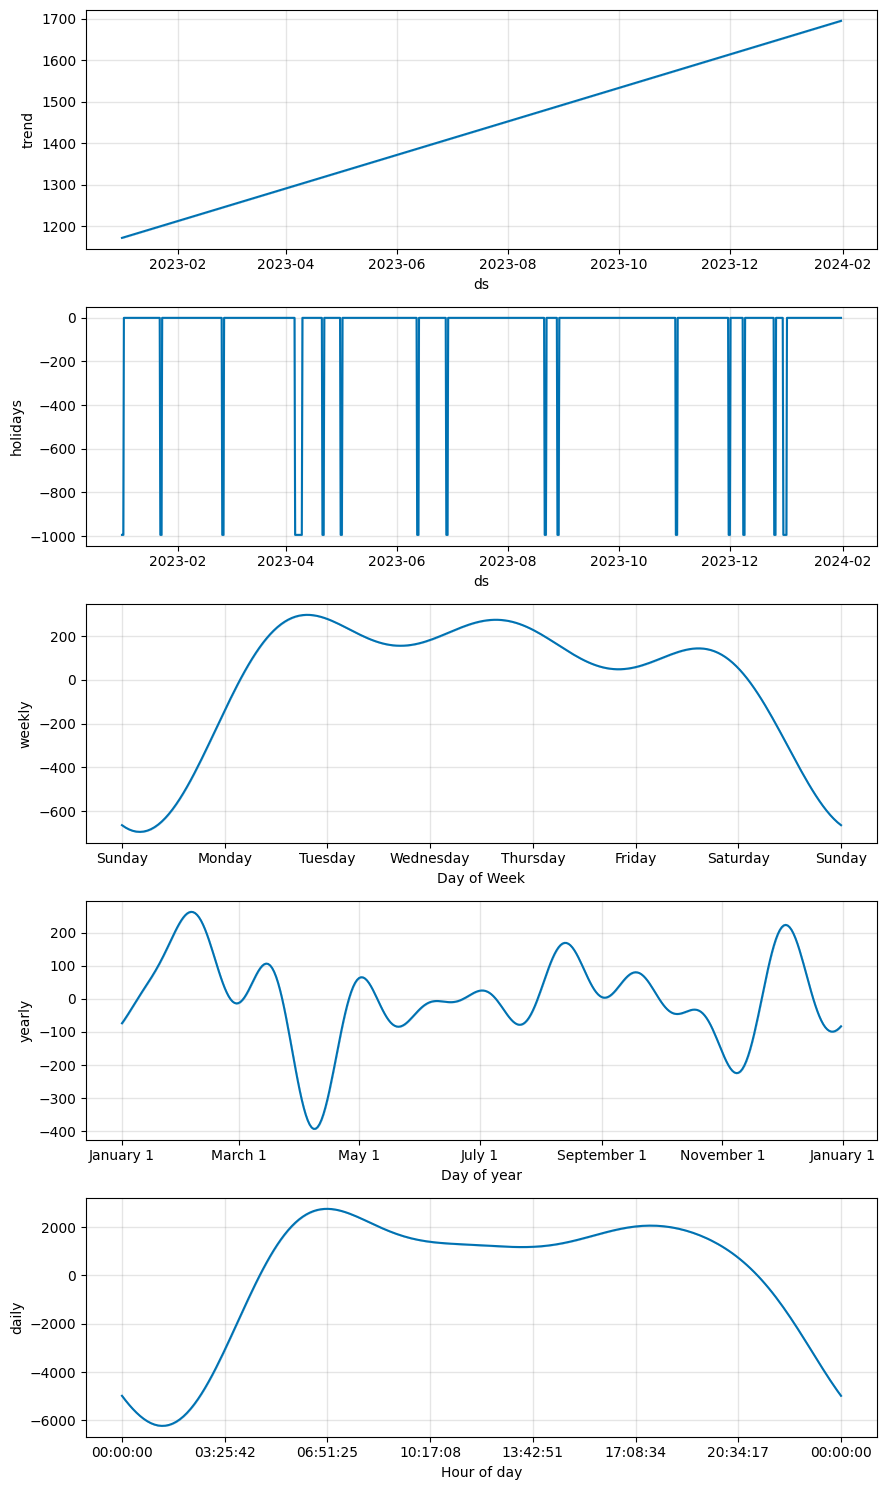

In [126]:
m.plot_components(forecast)
plt.show()

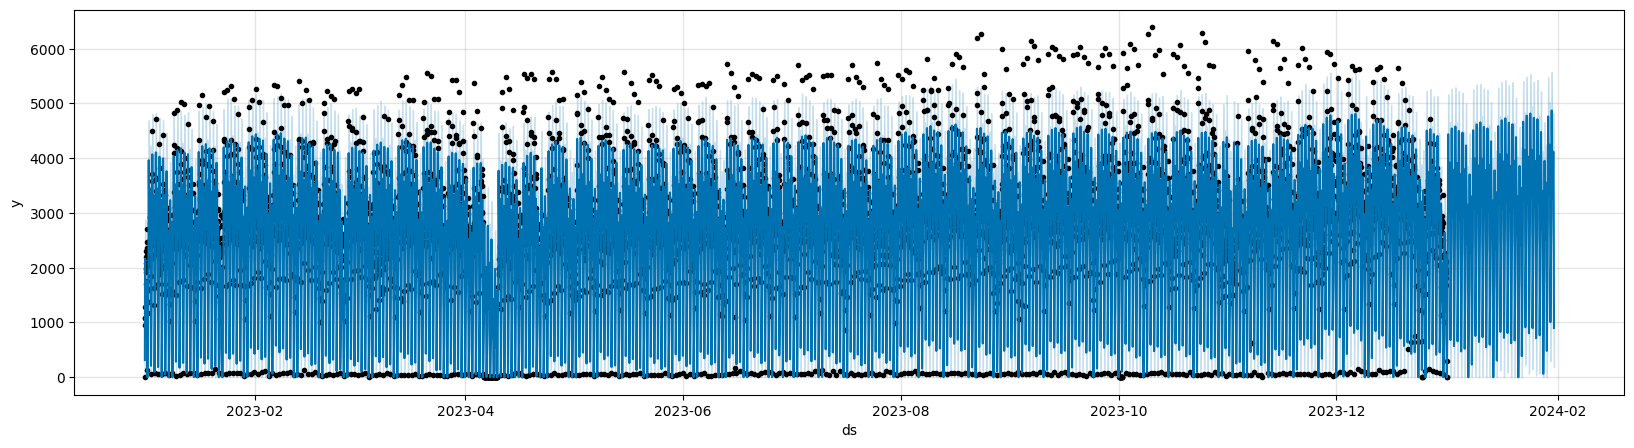

In [127]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
fig = m.plot(forecast,ax=ax)
plt.show()

In [132]:
cv_results = cross_validation(m, initial='270 days', period='30 days', horizon='30 days')

cv_results.head()


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/3 [00:00<?, ?it/s]00:18:54 - cmdstanpy - INFO - Chain [1] start processing
00:18:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:04<00:08,  4.09s/it]00:18:58 - cmdstanpy - INFO - Chain [1] start processing
00:19:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:08<00:04,  4.42s/it]00:19:02 - cmdstanpy - INFO - Chain [1] start processing
00:19:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:11<00:00,  3.87s/it]


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-10-03 05:00:00,2089.856954,1339.490210,2876.299146,2953,2023-10-02 22:00:00
1,2023-10-03 06:00:00,3462.813871,2688.838457,4216.077384,4399,2023-10-02 22:00:00
2,2023-10-03 07:00:00,3812.219934,3060.239489,4559.044736,5646,2023-10-02 22:00:00
3,2023-10-03 08:00:00,3429.444034,2731.024928,4178.949084,5332,2023-10-02 22:00:00
4,2023-10-03 09:00:00,2841.582865,2107.214651,3634.732914,3913,2023-10-02 22:00:00


In [133]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days 00:00:00,715373.454988,845.797526,702.942507,0.225956,0.347582,0.592593
1,3 days 07:00:00,717059.259708,846.793517,701.090169,0.225956,0.348143,0.592593
2,3 days 08:00:00,702229.945042,837.991614,693.972987,0.225956,0.346028,0.604938
3,3 days 09:00:00,686174.585480,828.356557,685.129478,0.224453,0.343151,0.604938
4,3 days 10:00:00,658931.647482,811.746049,669.836624,0.221537,0.338349,0.617284


In [121]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='100 days', period='30 days', horizon='7 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

23:57:02 - cmdstanpy - INFO - Chain [1] start processing
23:57:03 - cmdstanpy - INFO - Chain [1] done processing
23:57:11 - cmdstanpy - INFO - Chain [1] start processing
23:57:11 - cmdstanpy - INFO - Chain [1] done processing
23:57:18 - cmdstanpy - INFO - Chain [1] start processing
23:57:18 - cmdstanpy - INFO - Chain [1] done processing
23:57:25 - cmdstanpy - INFO - Chain [1] start processing
23:57:26 - cmdstanpy - INFO - Chain [1] done processing
23:57:33 - cmdstanpy - INFO - Chain [1] start processing
23:57:33 - cmdstanpy - INFO - Chain [1] done processing
23:57:42 - cmdstanpy - INFO - Chain [1] start processing
23:57:42 - cmdstanpy - INFO - Chain [1] done processing
23:57:50 - cmdstanpy - INFO - Chain [1] start processing
23:57:51 - cmdstanpy - INFO - Chain [1] done processing
23:57:59 - cmdstanpy - INFO - Chain [1] start processing
23:58:00 - cmdstanpy - INFO - Chain [1] done processing
23:58:08 - cmdstanpy - INFO - Chain [1] start processing
23:58:09 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  779.234374
1                     0.001                     0.10  759.416576
2                     0.001                     1.00  758.474170
3                     0.001                    10.00  756.108530
4                     0.010                     0.01  794.855758
5                     0.010                     0.10  763.922645
6                     0.010                     1.00  763.442251
7                     0.010                    10.00  763.480238
8                     0.100                     0.01  810.953488
9                     0.100                     0.10  781.316710
10                    0.100                     1.00  782.815745
11                    0.100                    10.00  782.061575
12                    0.500                     0.01  839.812234
13                    0.500                     0.10  813.948706
14                    0.5